# 🚚 Fase 05: Logistics & Delivery Performance
---
**Objetivo**: Analizar la eficiencia logística y el cumplimiento de promesas de entrega.

## 1. Carga de Datos
* Objetivo: Preparar el entorno y cargar los datasets necesarios para el análisis logístico.
* Datasets: orders_cleaned.csv y order_items_totals.csv.

In [3]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path_processed = "../data/processed"
# Convertir strings a objetos `datetime`:

# Carga de datos
orders = pd.read_csv(f'{path_processed}/orders_cleaned.csv',
                        parse_dates=['order_purchase_timestamp', 
                                      'order_approved_at', 
                                      'order_delivered_carrier_date', 
                                      'order_delivered_customer_date', 
                                      'order_estimated_delivery_date'])
customers = pd.read_csv(f"{path_processed}/customers_cleaned.csv")


In [5]:
orders.info()
orders.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   delivery_time_days             96476 non-null  float64       
 9   delta_estimated_days           96476 non-null  float64       
dtypes: datetime64[ns](5), float64(2), object(3)
memory usage: 7.6+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delta_estimated_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.0,-18.0


In [6]:
customers.info()
customers.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


## 2. Segmentación del Desempeño Logístico
* **Objetivo:** Clasificar los pedidos según el cumplimiento de la promesa de entrega.
* **Lógica:**
    * Pedidos con `delta_estimated_days` > 0: **Retrasados**.
    * Pedidos con `delta_estimated_days` <= 0: **A tiempo / Anticipados**.

In [8]:
# 1. Aseguro la creación de la categoría basada en el delta que ya tengo
orders['delivery_status'] = orders['delta_estimated_days'].apply(
    lambda x: 'Retrasado' if x > 0 else 'A tiempo / Anticipado'
)

# 2. Ahora sí, cuento cuántos hay de cada categoría (Status)
resumen_logistica = orders['delivery_status'].value_counts(normalize=True) * 100

print("--- Análisis de Cumplimiento de Entrega ---")
print(resumen_logistica)

# 3. Confirmo el número absoluto de retrasos
total_retrasos = (orders['delivery_status'] == 'Retrasado').sum()
print(f"\nTotal de pedidos con retraso: {total_retrasos}")

--- Análisis de Cumplimiento de Entrega ---
delivery_status
A tiempo / Anticipado    93.428264
Retrasado                 6.571736
Name: proportion, dtype: float64

Total de pedidos con retraso: 6535


#### 📝 Conclusión del análisis de la segmentación del desempeño logístico:
Insight de Entrega: El sistema logístico de Olist cumple con la promesa de entrega en el 93.4 % de los casos. Sin embargo, existe un 6.5 % de pedidos (6,535 órdenes) que llegan después de la fecha estimada, lo cual es un volumen crítico que impacta directamente en la satisfacción del cliente y posibles reclamos.

## 3. Análisis Geográfico de Retrasos
* **Objetivo:** Identificar los estados con mayor índice de incumplimiento.
* **Pregunta de Negocio:** ¿El retraso es culpa de la infraestructura de ciertos estados o es un problema global?
* **Técnica:** Agrupación por estado y cálculo del porcentaje de pedidos retrasados.

In [11]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delta_estimated_days,delivery_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,-8.0,A tiempo / Anticipado
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0,-6.0,A tiempo / Anticipado
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.0,-18.0,A tiempo / Anticipado


In [12]:
# Voy a cruzar los pedidos con los clientes para obtener el estado
query_delays_geo = """
SELECT
    customer_state,
    SUM(
        CASE
            WHEN delivery_status = 'Retrasado' THEN 1
            ELSE 0
        END
    ) AS delayed_orders,
    ROUND(SUM(
        CASE
            WHEN delivery_status = 'Retrasado' THEN 1
            ELSE 0
        END
    ) / COUNT(*) * 100, 2)  AS porcentage_delayed  
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
WHERE order_status = 'delivered'
GROUP BY 1
ORDER BY porcentage_delayed DESC
LIMIT 10;
"""
duckdb.sql(query_delays_geo).show()

┌────────────────┬────────────────┬────────────────────┐
│ customer_state │ delayed_orders │ porcentage_delayed │
│    varchar     │     int128     │       double       │
├────────────────┼────────────────┼────────────────────┤
│ AL             │             85 │              21.41 │
│ MA             │            125 │              17.43 │
│ SE             │             51 │              15.22 │
│ PI             │             66 │              13.87 │
│ CE             │            176 │              13.76 │
│ RR             │              5 │               12.2 │
│ BA             │            396 │              12.16 │
│ RJ             │           1495 │              12.11 │
│ PA             │            106 │              11.21 │
│ ES             │            214 │              10.73 │
├────────────────┴────────────────┴────────────────────┤
│ 10 rows                                    3 columns │
└──────────────────────────────────────────────────────┘



In [13]:
# Calculo el promedio nacional de retraso para comparar
national_average = (orders['delivery_status'] == 'Retrasado').mean() * 100
print(f"El porcentaje real de retraso nacional es: {national_average:.2f}%")

El porcentaje real de retraso nacional es: 6.57%


#### 📝 Insight de Volumen vs. Proporción: 
Existe una disparidad geográfica importante. Mientras que estados remotos como **RR** (Roraima) tienen un porcentaje alto (**12.2%**) con solo **5 retrasos** debido a su bajo volumen, el caso de **RJ** (Rio de Janeiro) es alarmante: mantiene un porcentaje similar (**12.1%**) pero con un volumen masivo de **1,495 retrasos**, lo que sugiere problemas de seguridad o saturación urbana que difieren de los problemas de distancia del Norte. Esto indica que el problema en RJ es estructural y de alto impacto para la empresa.

## 4. Correlación: Logística vs. Satisfacción del Cliente
* **Objetivo:** Cuantificar la caída en el `review_score` cuando un pedido se retrasa.
* **Hipótesis:** Existe una relación inversamente proporcional entre los días de retraso (`delta_estimated_days`) y la calificación del cliente.

In [16]:
# 1. Cargo el dataset de reviews
orders_reviews = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')

In [17]:
orders_reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [18]:
# 2. Uno mi dataframe de logística (orders) y reviews
satisfaction_df = pd.merge(
    orders[['order_id', 'delivery_status', 'delta_estimated_days']],
    orders_reviews[['order_id', 'review_score']],
    on='order_id'
)
satisfaction_df.head(3)

,order_id,delivery_status,delta_estimated_days,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,A tiempo / Anticipado,-8.0,4
1,53cdb2fc8bc7dce0b6741e2150273451,A tiempo / Anticipado,-6.0,4
2,47770eb9100c2d0c44946d9cf07ec65d,A tiempo / Anticipado,-18.0,5


In [19]:
# 3. Calculo el Score Promedio según el Status de entrega
average_satisfaction = satisfaction_df.groupby('delivery_status')['review_score'].mean().round(3)
print("Impacto del cumplimiento en la calificación promedio:")
print(average_satisfaction)

Impacto del cumplimiento en la calificación promedio:
delivery_status
A tiempo / Anticipado    4.212
Retrasado                2.271
Name: review_score, dtype: float64


##### Calculo de variacion percentual:
* Variación % = ( Valor_{nuevo} - Valor_{antiguo} ) / {Valor_{antiguo}} x 100
* Valor antiguo (A tiempo): 4.21
* Valor nuevo (Retrasado): 2.27
* Cálculo: (2.27 - 4.21)/4.21 = -0.4608
* Multiplicado por 100, nos da una caída del 46.08%.

#### 📝 Conclusión de Negocio: El Costo Reputacional del Retraso
Impacto Crítico en el NPS (Net Promoter Score): Los datos demuestran que el cumplimiento de la promesa de entrega es el factor determinante de la satisfacción en Olist. Mientras que los pedidos entregados 'A tiempo' mantienen una calificación saludable de 4.21 estrellas, los pedidos 'Retrasados' sufren una degradación del 46% en su valoración, cayendo a 2.27 estrellas.

Implicación Financiera: Una calificación de 2.27 indica que la mayoría de estos 6,535 clientes son ahora "detractores" de la marca. El costo de adquisición de un nuevo cliente es mucho más alto que el de retención; por lo tanto, cada retraso no es solo un fallo logístico, sino una pérdida directa de valor del cliente y un aumento en los costos de atención al cliente (tickets de reclamo).

## 5. Análisis del Costo de Envío (Freight) y Eficiencia
* **Objetivo:** Determinar si existe una correlación entre el monto pagado por envío y la velocidad de entrega.
* **Hipótesis:** Los fletes más costosos deberían estar asociados a distancias mayores y, por ende, a mayores tiempos de entrega o riesgos de retraso.

In [23]:
# 1. Cargo el dataset que ya tiene los totales por orden (precio y flete)
order_items_totals = pd.read_csv('../data/processed/order_items_totals.csv')

# la tabla para ver los estados: 
customers = pd.read_csv('../data/processed/customers_cleaned.csv')

In [24]:
order_items_totals.info()
order_items_totals.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98666 entries, 0 to 98665
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             98666 non-null  object 
 1   total_items_price    98666 non-null  float64
 2   total_items_freight  98666 non-null  float64
 3   order_grand_total    98666 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.0+ MB


,order_id,total_items_price,total_items_freight,order_grand_total
0,00010242fe8c5a6d1ba2dd792cb16214,58.9,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,239.9,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,199.0,17.87,216.87


In [77]:
# 2. Primero: Traigo el 'customer_state' a la tabla de órdenes
# Uno `orders` con `customers` usando 'customer_id'
orders_with_geo = pd.merge(
    orders,
    customers[['customer_id','customer_state']],
    on='customer_id',
    how='left'
)
# orders_with_geo.head(3) w!

In [79]:
orders_with_geo.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delta_estimated_days,delivery_status,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,-8.0,A tiempo / Anticipado,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0,-6.0,A tiempo / Anticipado,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.0,-18.0,A tiempo / Anticipado,GO


In [81]:
# 3. Segundo: Uno el resultado anterior con el flete (order_items)
df_freight = pd.merge(
    orders_with_geo[['order_id', 'delivery_status', 'delivery_time_days', 'delta_estimated_days', 'customer_state']],
    order_items_totals[['order_id', 'total_items_freight']], 
    on='order_id'
) 
df_freight.head(3)

,order_id,delivery_status,delivery_time_days,delta_estimated_days,customer_state,total_items_freight
0,e481f51cbdc54678b7cc49136f2d6af7,A tiempo / Anticipado,8.0,-8.0,SP,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,A tiempo / Anticipado,13.0,-6.0,BA,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,A tiempo / Anticipado,9.0,-18.0,GO,19.22


In [83]:
# 4. Calculo el costo promedio de flete por Status de Entrega
freight_analysis = df_freight.groupby('delivery_status')['total_items_freight'].mean()
print("Costo promedio de envío por estado de entrega:")
print(freight_analysis)

Costo promedio de envío por estado de entrega:
delivery_status
A tiempo / Anticipado    22.651742
Retrasado                25.245890
Name: total_items_freight, dtype: float64


🎯 Conclusión Refinada: La Paradoja del Flete
1. Evidencia de Costo: Los pedidos Retrasados pagan un 11.4% más de flete en promedio ($25.24$ vs $22.65$). Esto confirma que los retrasos están ligados a la distancia (zonas que son más caras de alcanzar).
2. Impacto Cruzado (Satisfacción): Al conectar esto con lo que vió ayer, entiendo por qué la nota cae de 4.2 a 2.2 estrellas. No es solo que el paquete llegue tarde; es que el cliente siente que pagó más por un servicio que falló.
3. Insight para el Negocio: El precio del flete en Olist no garantiza prioridad. La empresa debería considerar subsidiar fletes o mejorar la red de distribución en los estados del Norte/Noreste para evitar que el alto costo de envío se convierta en una garantía de insatisfacción.

In [85]:
# 5. Analizar Flete y Análisis
# Esto va a decir si es 'Bajo', 'Medio', 'Alto' o 'Muy Alto'
df_freight['freight_tier'] = pd.qcut(df_freight['total_items_freight'], 4,
                                     labels = ['Económico', 'Estándar', 'Premium', 'Muy Alto'])
df_freight

,order_id,delivery_status,delivery_time_days,delta_estimated_days,customer_state,total_items_freight,freight_tier
0,e481f51cbdc54678b7cc49136f2d6af7,A tiempo / Anticipado,8.0,-8.0,SP,8.72,Económico
1,53cdb2fc8bc7dce0b6741e2150273451,A tiempo / Anticipado,13.0,-6.0,BA,22.76,Premium
2,47770eb9100c2d0c44946d9cf07ec65d,A tiempo / Anticipado,9.0,-18.0,GO,19.22,Premium
3,949d5b44dbf5de918fe9c16f97b45f8a,A tiempo / Anticipado,13.0,-13.0,RN,27.20,Muy Alto
4,ad21c59c0840e6cb83a9ceb5573f8159,A tiempo / Anticipado,2.0,-10.0,SP,8.72,Económico
...,...,...,...,...,...,...,...
98661,9c5dedf39a927c1b2549525ed64a053c,A tiempo / Anticipado,8.0,-11.0,SP,13.08,Económico
98662,63943bddc261676b46f01ca7ac2f7bd8,A tiempo / Anticipado,22.0,-2.0,SP,20.10,Premium
98663,83c1379a015df1e13d02aae0204711ab,A tiempo / Anticipado,24.0,-6.0,BA,65.02,Muy Alto
98664,11c177c8e97725db2631073c19f07b62,A tiempo / Anticipado,17.0,-21.0,RJ,81.18,Muy Alto


In [87]:
# 2. Calcul0 la tasa de retraso por cada nivel de flete
# Quiero saber: ¿A mayor precio, menor retraso?
freight_delay_rate = df_freight.groupby('freight_tier', observed=False).agg(
    promedio_dias_entrega=('delivery_time_days', 'mean'),
    porcentaje_retraso=('delivery_status', lambda x : (x=='Retrasado').mean() * 100),
    cantidad_pedidos=('order_id', 'count'),
).reset_index()

print("Análisis de Eficiencia por Nivel de Costo de Envío:")
print(freight_delay_rate)

Análisis de Eficiencia por Nivel de Costo de Envío:
  freight_tier  promedio_dias_entrega  porcentaje_retraso  cantidad_pedidos
0    Económico               7.308313            4.306084             24686
1     Estándar              12.499543            6.839651             24665
2      Premium              13.570097            7.565923             24650
3     Muy Alto              15.007677            7.784310             24665


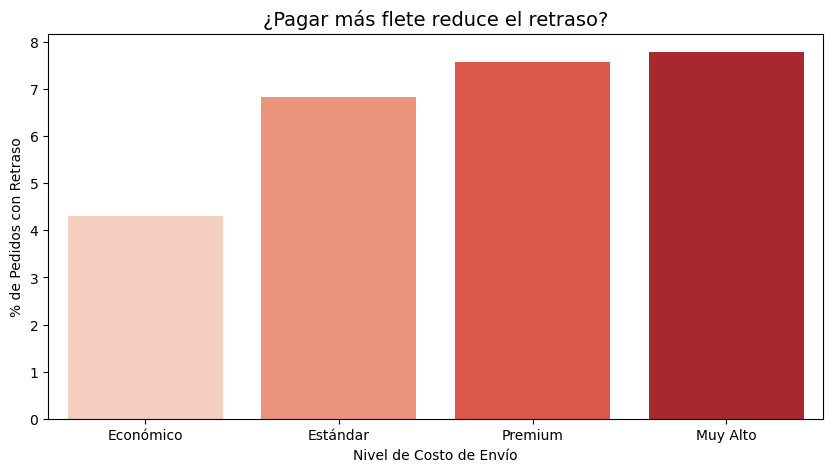

In [89]:
# 3. Visualización de la "Promesa Incumplida"
plt.figure(figsize=(10, 5))
sns.barplot(
    x='freight_tier', 
    y='porcentaje_retraso', 
    data=freight_delay_rate, 
    palette='Reds', 
    hue='freight_tier', 
    legend=False
)
plt.title('¿Pagar más flete reduce el retraso?', fontsize=14)
plt.ylabel('% de Pedidos con Retraso')
plt.xlabel('Nivel de Costo de Envío')
plt.show()

#### Conclusión para tu celda de análisis:
"El gráfico confirma una relación irónica: el nivel de flete más costoso es el que sufre mayor incumplimiento. Esto valida que el precio del envío en Olist está ligado exclusivamente a la complejidad geográfica y no a una mejora en la prioridad del servicio."

## 6. Correlación Multivariable: Logística vs. Satisfacción
* **Objetivo**: Cuantificar la fuerza de la relación entre el costo del flete, los tiempos de entrega y la calificación final del usuario mediante una matriz de correlación.
* **Hipótesis**: El retraso en la entrega (delta_estimated_days) es la variable con mayor impacto negativo sobre el review_score, superando al costo del flete o al tiempo total de tránsito.

In [91]:
# 1. Selecciono las columnas numéricas clave para el análisis
# Incluyo precio, flete, días de entrega, el delta (retraso) y la calificación
df_corr = pd.merge(
    df_freight,
    orders_reviews[['order_id', 'review_score']],
    on='order_id'
)
df_corr.head(3)

,order_id,delivery_status,delivery_time_days,delta_estimated_days,customer_state,total_items_freight,freight_tier,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,A tiempo / Anticipado,8.0,-8.0,SP,8.72,Económico,4
1,53cdb2fc8bc7dce0b6741e2150273451,A tiempo / Anticipado,13.0,-6.0,BA,22.76,Premium,4
2,47770eb9100c2d0c44946d9cf07ec65d,A tiempo / Anticipado,9.0,-18.0,GO,19.22,Premium,5


In [95]:
# 2. Selecciono solo las variables que quiero correlacionar
columns_interest = [
    'delivery_time_days', 
    'delta_estimated_days', 
    'total_items_freight', 
    'review_score'
]
correlation_matrix = df_corr[columns_interest].corr()
correlation_matrix

,delivery_time_days,delta_estimated_days,total_items_freight,review_score
delivery_time_days,1.000000,0.601624,0.167127,-0.333660
delta_estimated_days,0.601624,1.000000,-0.050431,-0.266764
total_items_freight,0.167127,-0.050431,1.000000,-0.088645
review_score,-0.333660,-0.266764,-0.088645,1.000000


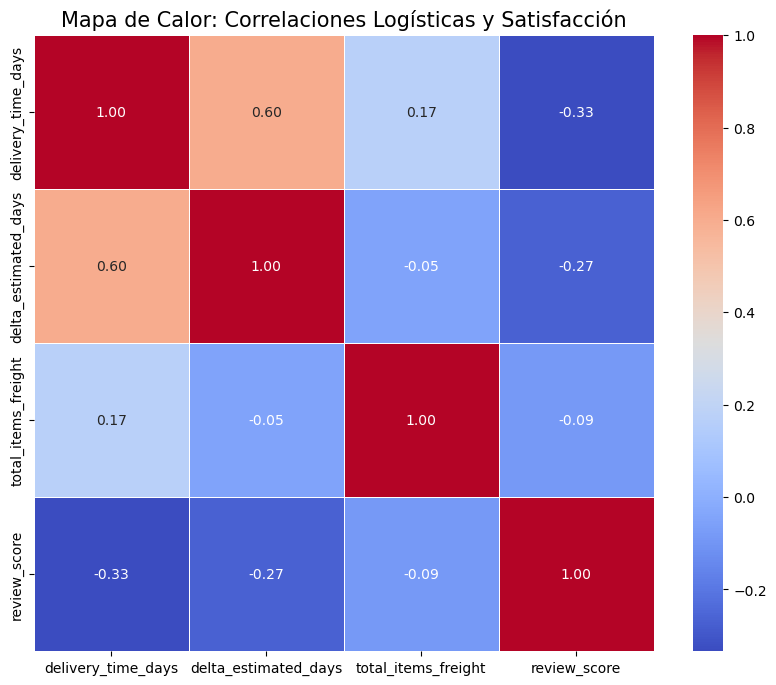

In [101]:
# 3. Visualización con un Heatmap (Mapa de Calor)
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor: Correlaciones Logísticas y Satisfacción', fontsize=15)
# Guardo en formato PNG con alta resolución y ajustando el espacio para que no se corte el texto
plt.savefig('../reports/figures/logistics_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()